In [25]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121+
!pip3 install matplotlib IPython tqdm
!pip3 install soundfile torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu121+


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


INFO: pip is looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/519.2 kB ? eta -:--:--
     ------------------------------------- 519.2/519.2 kB 16.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/518.6 kB ? eta -:--:--
     ---------------------------------------- 518.6/518.6 kB ? eta 0:00:00
     ---------------------------------------- 0.0/518.5 kB ? eta -:--:--
     ---------------------------------------- 518.5/518.5 kB ? eta 0:00:00
     ---------------------------------------- 0.0/517.2 kB ? eta -:--:--
     ---------------------------------------- 517.2/517.2 kB ? eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stri

ERROR: Cannot install torchmetrics==0.10.0, torchmetrics==0.10.1, torchmetrics==0.10.2, torchmetrics==0.10.3, torchmetrics==0.11.0, torchmetrics==0.11.1, torchmetrics==0.11.2, torchmetrics==0.11.3, torchmetrics==0.11.4, torchmetrics==0.2.0, torchmetrics==0.3.0, torchmetrics==0.3.1, torchmetrics==0.3.2, torchmetrics==0.4.1, torchmetrics==0.5.0, torchmetrics==0.5.1, torchmetrics==0.6.0, torchmetrics==0.6.1, torchmetrics==0.6.2, torchmetrics==0.7.0, torchmetrics==0.7.1, torchmetrics==0.7.2, torchmetrics==0.7.3, torchmetrics==0.8.0, torchmetrics==0.8.1, torchmetrics==0.8.2, torchmetrics==0.9.0, torchmetrics==0.9.1, torchmetrics==0.9.2, torchmetrics==0.9.3, torchmetrics==1.0.0, torchmetrics==1.0.1, torchmetrics==1.0.2, torchmetrics==1.0.3, torchmetrics==1.1.0, torchmetrics==1.1.1, torchmetrics==1.1.2, torchmetrics==1.2.0 and torchmetrics==1.2.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/depen

In [54]:
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchaudio.datasets import SPEECHCOMMANDS
import os
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
print('Train size:',len(train_set))
test_set = SubsetSC("testing")
print('Test size:',len(test_set))

validate_set = SubsetSC("validation")
print('Valid size:',len(validate_set))
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]
waveform.to(device)
labels = ['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']
def label_to_index(word):
    # Return the position of the word in labels
    # This is the inverse of index_to_label
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

word_start = labels[5]
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)




def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets



batch_size = 7075
log_interval = 150
n_epoch = 51
losses = []
samples_size = 24

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle= False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
valid_loader = DataLoader(
    validate_set,
    batch_size=batch_size,
    shuffle= False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
class My_model(nn.Module):
    def __init__(self, input_size=98, hidden_size=2048 , n_output=len(labels), num_layers =4 ,dropout=0.4 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=num_layers,dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, n_output)

    def forward(self, x):
        global out # expose result
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        return F.log_softmax(out,dim=-1)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, epoch, log_interval,samples_size,model_input_size):
    global losses, optimizer, transform
    losses = []
    model.train()

    for batch_idx, (inputs,results) in enumerate(train_loader):
        batch_real_size = inputs.shape[0]
        results = results.to(device)
        inputs = inputs.to(device)

        # apply transform and model on whole batch directly on device
        inputs = transform(inputs) 

        inputs = inputs.reshape(batch_real_size, samples_size,model_input_size)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = F.nll_loss(output,results)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def test(model, epoch,samples_size,model_input_size):
    predictions =[]
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        batch_real_size = data.shape[0]
        data = data.reshape(batch_real_size, samples_size,model_input_size)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        predictions.extend(pred.cpu().numpy())
    
    print(f"Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")
    return (predictions, correct)

valid_correct_results = []
def valid(model, samples_size,model_input_size):
    predictions =[]
    model.eval()
    correct = 0
    for data, target in valid_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        batch_real_size = data.shape[0]
        data = data.reshape(batch_real_size, samples_size,model_input_size)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        predictions.extend(pred.cpu().numpy())
        valid_correct_results.extend(target.cpu().numpy())
    
    print(f"Validate Results: \tAccuracy: {correct}/{len(valid_loader.dataset)} ({100. * correct / len(valid_loader.dataset):.0f}%)\n")
    return (predictions, correct)

def valid_train(model, epoch,samples_size, model_input_size):
    predictions =[]
    model.eval()
    correct = 0
    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        batch_real_size = data.shape[0]
        data = data.reshape(batch_real_size, samples_size,model_input_size)
        output = model(data)
        
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        predictions.extend(pred.cpu().numpy())

    print(f"\nTrain Epoch: {epoch}\tAccuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)\n")
    return (predictions, correct)

Train size: 84843
Test size: 11005
Valid size: 9981
down --> tensor(5) --> down


In [9]:
params = {'scheduler_step_size': 5,
 'scheduler_gamma': 0.7,
 'opt_lr': 0.001,
 'model_num_layers': 2,
 'model_hidden_size': 1024,
 'model_dropout': 0.3,
 'mel_n_mfcc': 8,
 'mel_n_fft': 200,
 'mel_center': False}
mel_n_fft = params.get('mel_n_fft')
mel_n_mfcc = params.get('mel_n_mfcc')
mel_center = params.get('mel_center')
opt_lr = params.get('opt_lr')
model_hidden_size = params.get('model_hidden_size')
model_num_layers = params.get('model_num_layers')
model_dropout = params.get('model_dropout')
scheduler_step_size = params.get('scheduler_step_size')
scheduler_gamma = params.get('scheduler_gamma')
print('Params:',params)

Params: {'scheduler_step_size': 5, 'scheduler_gamma': 0.7, 'opt_lr': 0.001, 'model_num_layers': 2, 'model_hidden_size': 1024, 'model_dropout': 0.3, 'mel_n_mfcc': 8, 'mel_n_fft': 200, 'mel_center': False}


In [10]:
transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=mel_n_mfcc,
        melkwargs={"n_fft": mel_n_fft, "n_mels": mel_n_mfcc + 20, "center": mel_center},
    )
transform = transform.to(device)
waveform = waveform.to(device)
model_input_size = transform(waveform).shape[2]
model = My_model(input_size=model_input_size, hidden_size=model_hidden_size , n_output=len(labels), num_layers =model_num_layers ,dropout=model_dropout)
model.to(device)
model_number_of_params = count_parameters(model)
print("Number of parameters: %s" % model_number_of_params)

optimizer = optim.Adam(model.parameters(), lr=opt_lr, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)  # reduce the learning after 3 epochs by a factor of 10

for epoch in range(1, n_epoch + 1):
    print("Epoch #",epoch,":")
    train(model, epoch, log_interval,mel_n_mfcc,model_input_size)
    train_pred, train_correct = valid_train(model,epoch,mel_n_mfcc,model_input_size)
    test_pred, test_correct =test(model, epoch,mel_n_mfcc,model_input_size)
    scheduler.step()

Number of parameters: 13286435
Epoch # 1 :
Train Epoch: 1 [0/84843 (0%)]	Loss: 3.554262

Train Epoch: 1	Accuracy: 26373/84843 (31%)


Test Epoch: 1	Accuracy: 3268/11005 (30%)

Epoch # 2 :
Train Epoch: 2 [0/84843 (0%)]	Loss: 2.475752

Train Epoch: 2	Accuracy: 32278/84843 (38%)


Test Epoch: 2	Accuracy: 3875/11005 (35%)

Epoch # 3 :
Train Epoch: 3 [0/84843 (0%)]	Loss: 2.144263

Train Epoch: 3	Accuracy: 48638/84843 (57%)


Test Epoch: 3	Accuracy: 5832/11005 (53%)

Epoch # 4 :
Train Epoch: 4 [0/84843 (0%)]	Loss: 1.495846

Train Epoch: 4	Accuracy: 55896/84843 (66%)


Test Epoch: 4	Accuracy: 6715/11005 (61%)

Epoch # 5 :
Train Epoch: 5 [0/84843 (0%)]	Loss: 1.232093

Train Epoch: 5	Accuracy: 60764/84843 (72%)


Test Epoch: 5	Accuracy: 7109/11005 (65%)

Epoch # 6 :
Train Epoch: 6 [0/84843 (0%)]	Loss: 1.034106

Train Epoch: 6	Accuracy: 64385/84843 (76%)


Test Epoch: 6	Accuracy: 7435/11005 (68%)

Epoch # 7 :
Train Epoch: 7 [0/84843 (0%)]	Loss: 0.878949

Train Epoch: 7	Accuracy: 67462/84843 (80%

In [109]:
train_pred, train_correct = valid_train(model,'final',mel_n_mfcc,model_input_size)
test_pred, test_correct =test(model, 'final',mel_n_mfcc,model_input_size)
valid_pred, valid_correct = valid(model,mel_n_mfcc,model_input_size)


Train Epoch: final	Accuracy: 84808/84843 (100%)


Test Epoch: final	Accuracy: 8223/11005 (75%)

Validate Results: 	Accuracy: 7837/9981 (79%)



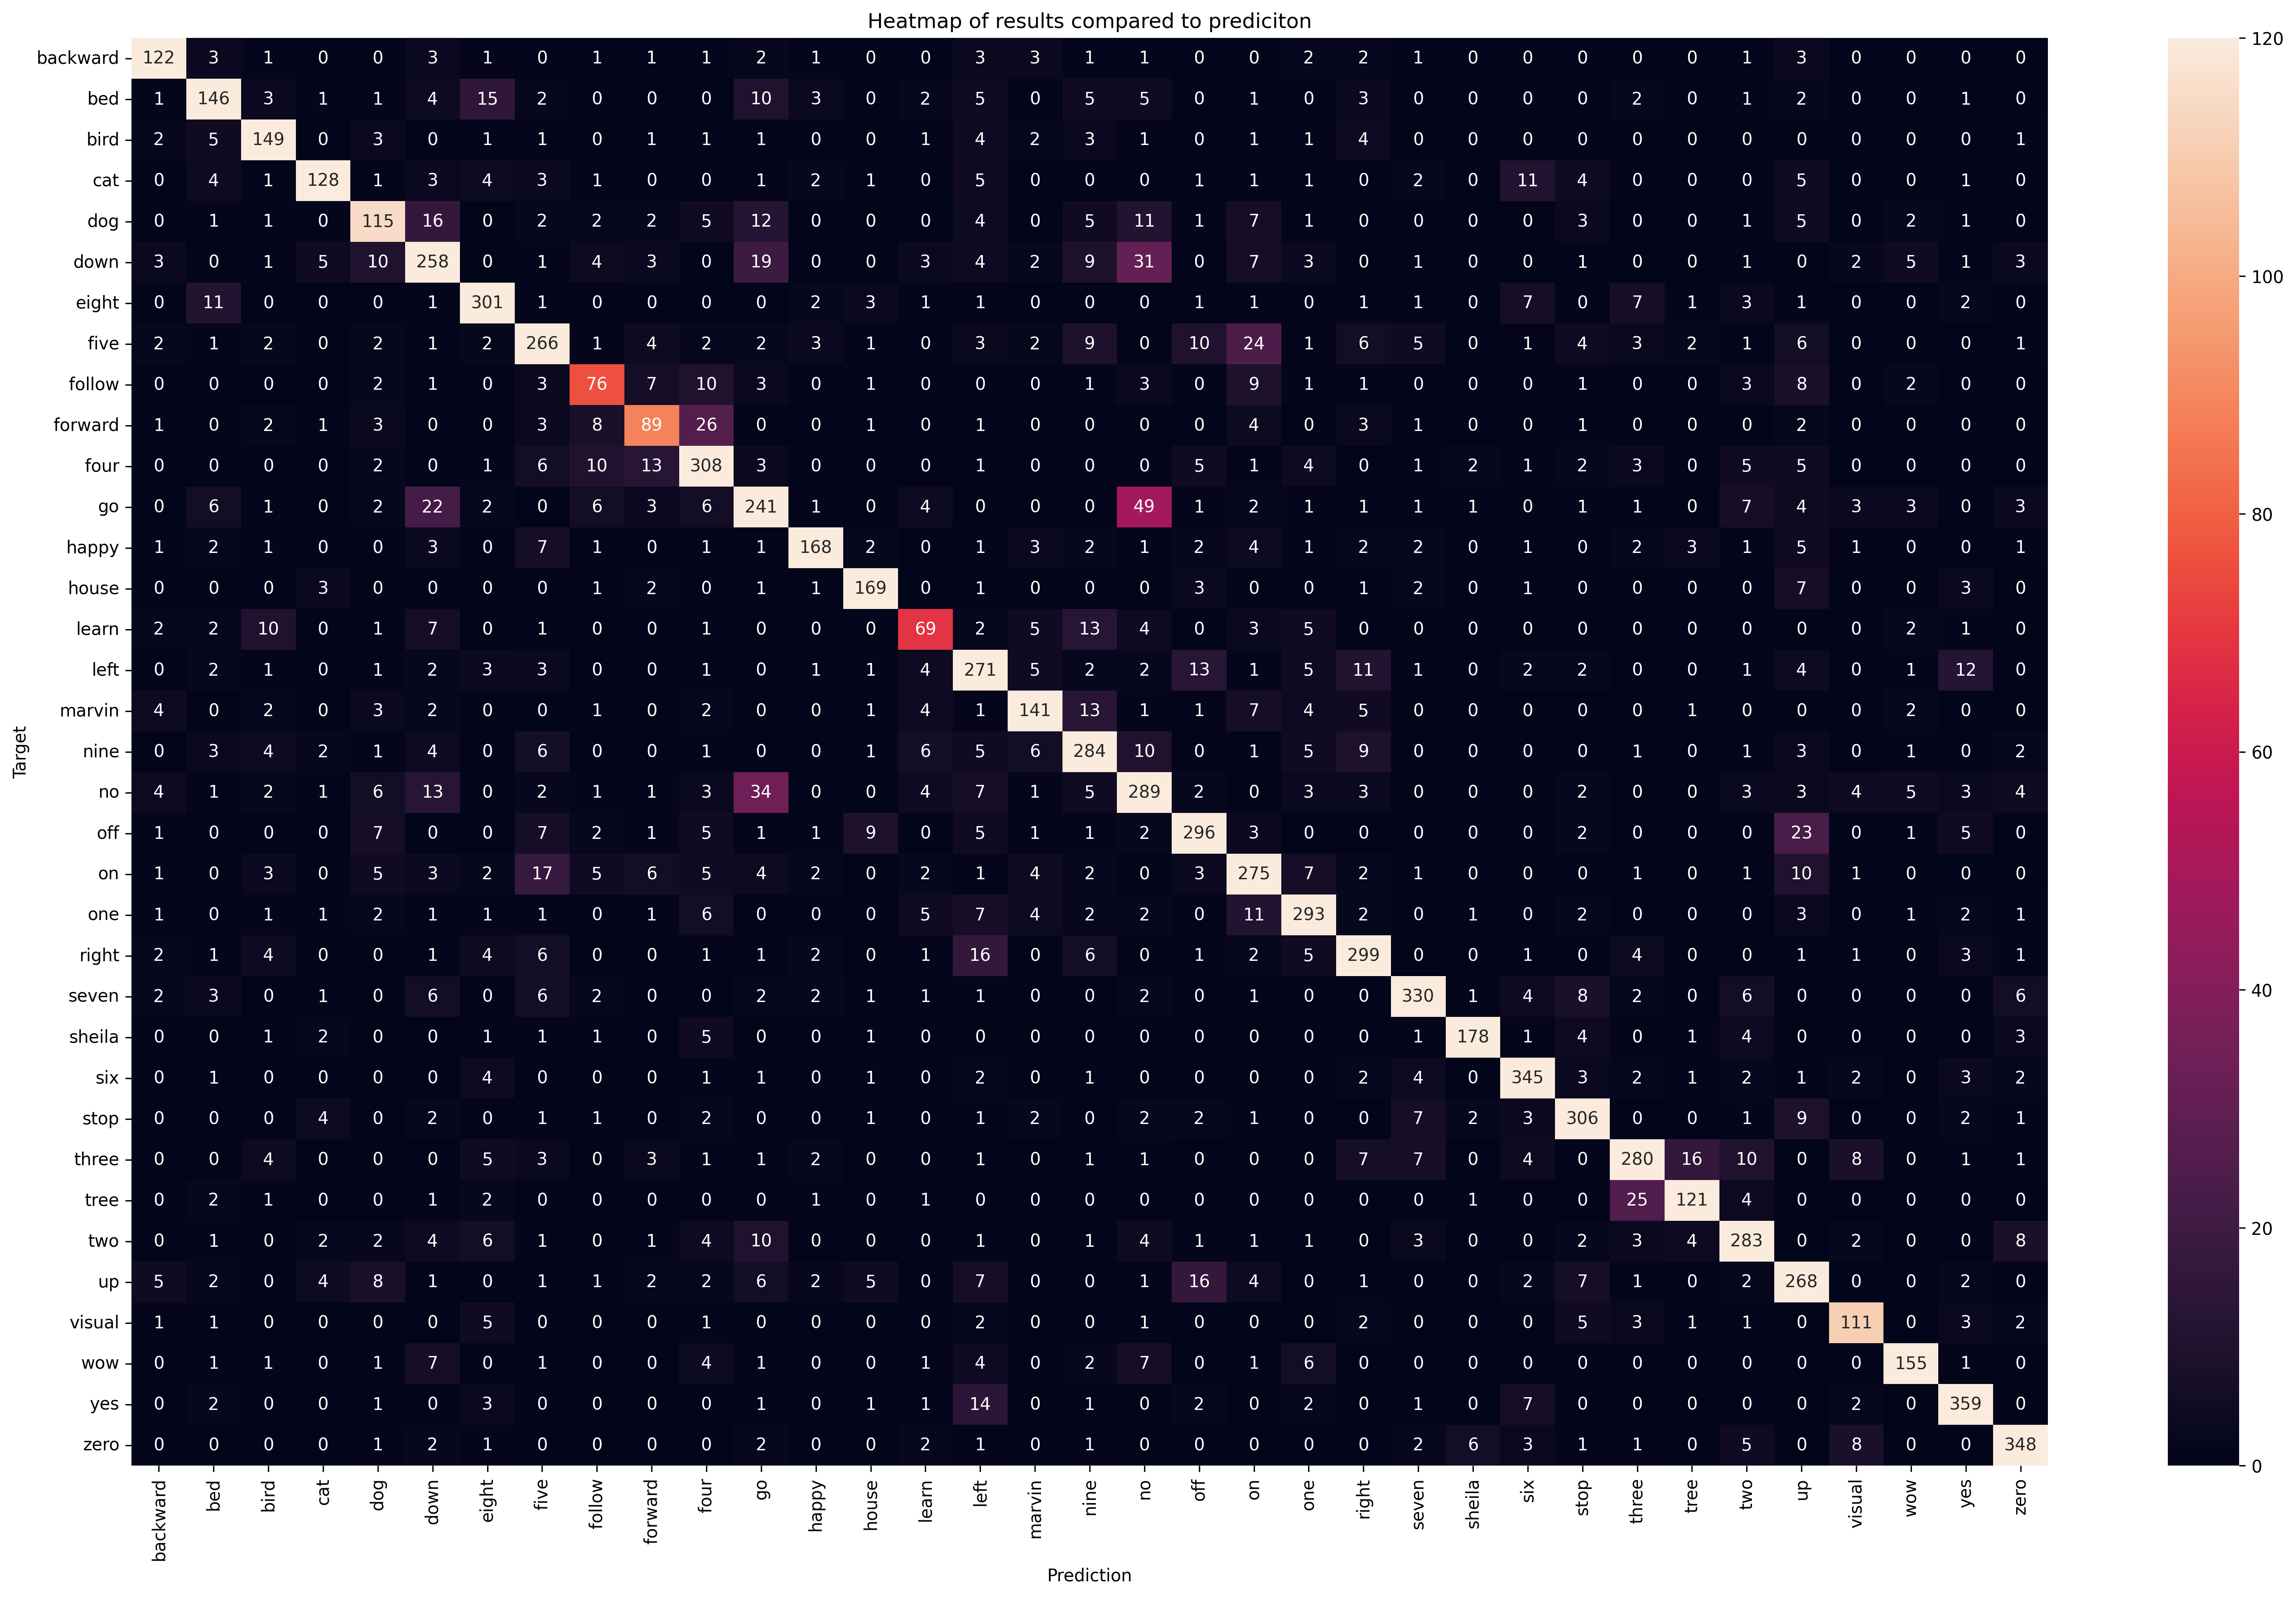

In [108]:
results= [[0 for _ in range(len(labels))] for _ in range(len(labels))]
for c,p in zip(valid_correct_results, valid_pred):
    results[c][p]+=1
plt.figure(figsize=(25, 15), dpi=300) 
s = sns.heatmap(results, xticklabels=labels,yticklabels=labels, annot=True,fmt='d', vmax=120)
s.set(xlabel='Prediction', ylabel='Target')
plt.title('Heatmap of results compared to prediciton')
plt.show()